# Neuronowe architektury

@autor: Marcin Kostrzewa

In [1]:
%load_ext autoreload

In [81]:
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import torch
import torch.nn as nn
import torch.optim as optim
from keras.layers import LSTM, Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam
from pyts.transformation import ROCKET
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from torch.utils.data import DataLoader, TensorDataset

from src.utils import get_standarized_data, get_tsne_plot, plot_loss_and_metric

In [3]:
plt.style.use('rose-pine')
SEED = 30_08_2000

### Liniowa regresja jako punkt wyjścia

W przypadku liniowej regresji modelujemy zależność pewnego $Y$ od pewych $X_i$, $i=1,2,...,n$ jako:

$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_n X_n,$$

gdzie $\beta_i$ to współczynniki regresji.


Wszystko jest w porządku do czasu, gdy będziemy chcieli modelować $Y$ za pomocą bardziej złożonych (czytaj **nieliniowych**) zależności.

In [43]:
linear_data = np.load(os.path.join('data', 'linear.npz'))
linear_X, linear_y = linear_data['X'], linear_data['Y']

Zaczynamy od prostej, liniowej zależności:
$$
Y = X_1 +2X_2 + 3X_3  - X_4  + 4 X_5 + \varepsilon.
$$

$\varepsilon$ to szum, który dodajemy, by było model był bardziej rzeczywisty &mdash; nie ma bowiem nic idealnego na świecie.

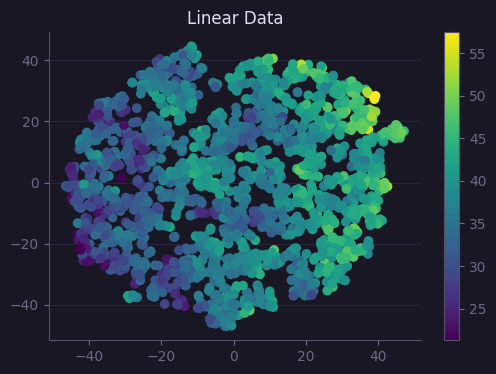

In [44]:
get_tsne_plot(linear_X, linear_y, 'Linear Data')

In [45]:
linear_X_train, linear_X_test, linear_y_train, linear_y_test = \
    train_test_split(linear_X, linear_y, test_size=0.2)

In [46]:
lr = LinearRegression()

lr.fit(linear_X_train, linear_y_train)
print("R^2: ", lr.score(linear_X_test, linear_y_test))
preds = lr.predict(linear_X_test)
print("Mean absolute error: ", mean_absolute_error(linear_y_test, preds))

R^2:  0.9905861451581732
Mean absolute error:  0.3941677929660496


Tak jak można było przewidzieć dopasowanie jest bardzo dobre. Sięgnijmy teraz po dane, gdzie zależność jest o wiele mniej liniowa, a wygląda następująco:


$$
Y = X_1 X_2 + 3X_3^2 \sin(X_4) + \log(e^{X_5} + 2) + \varepsilon.
$$

In [47]:
nonlinear_data = np.load(os.path.join('data', 'nonlinear.npz'))
nonlinear_X, nonlinear_y = nonlinear_data['X'], nonlinear_data['Y']

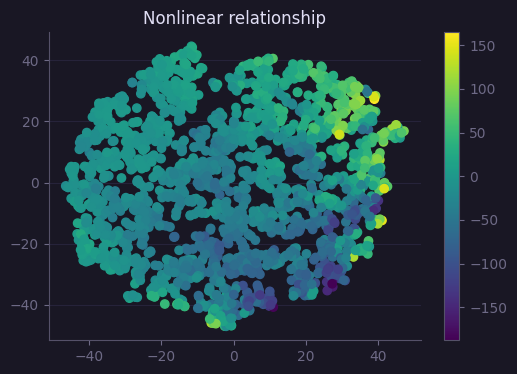

In [48]:
get_tsne_plot(nonlinear_X, nonlinear_y, 'Nonlinear relationship')

In [49]:
nl_X_train, nl_X_test, nl_y_train, nl_y_test = \
    train_test_split(nonlinear_X, nonlinear_y, test_size=0.2)

In [50]:
nl_X_train_scaled, nl_X_test_scaled = get_standarized_data(nl_X_train, nl_X_test)

In [51]:
lr.fit(nl_X_train_scaled, nl_y_train)

print("R^2 score: ", lr.score(nl_X_test_scaled, nl_y_test))

lr_preds = lr.predict(nl_X_test_scaled)
print("Mean Absolute Error: ", mean_absolute_error(nl_y_test, lr_preds))

R^2 score:  0.30128360075503235
Mean Absolute Error:  23.976056175052655


Problemem stała się większa złożoność zależności pomiedzy zmienną wyjaśnianą a wyjaśniającymi.

No to sięgnijmy po sieć &hellip; czyli w zasadzie po co?

<img src="media/ffn.png" width='770' height='600'>

In [52]:
train_dataset = tf.data.Dataset.from_tensor_slices((nl_X_train_scaled, nl_y_train))
train_dataset = train_dataset.shuffle(324).batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((nl_X_test_scaled, nl_y_test))
test_dataset = test_dataset.batch(32)

Pierwszy model stworzymy sobie w Kerasie.

Modele w nim można tworzyć na trzy sposoby:
* `Sequential` &mdash; warstwy są dodawane jedna po drugiej,
* `Functional` &mdash; [źródło](https://keras.io/guides/functional_api/),
* `Model` &mdash; dziedziczenie po klasie `Model` z Kerasa ([źródło](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)).

In [53]:
nn_trial = Sequential()

nn_trial.add(Input(shape=(5, )))
nn_trial.add(Dense(20, activation='relu'))
nn_trial.add(Dense(1, activation='linear'))

nn_trial.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
nn_trial.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 20)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141 (564.00 B)

 Trainable params: 141 (564.00 B)

 Non-trainable params: 0 (0.00 B)

In [54]:
nn_trial_hist = nn_trial.fit(train_dataset, epochs=500)

Epoch 1/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 1845.1039 - mae: 32.3578
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1967.3148 - mae: 33.5811
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1856.4459 - mae: 32.3178
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - loss: 1806.0626 - mae: 32.1705
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - loss: 1695.8350 - mae: 30.8849
Epoch 6/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 1654.3750 - mae: 30.2800
Epoch 7/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 1653.1078 - mae: 30.5086
Epoch 8/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 1564.7235 - mae: 29.5967
Epoch 9/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 1550.9810 - mae: 29.2017
Epoch 10/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 1454.5636 - mae: 28.0598
Epoch 11/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - loss: 1474.4482 - mae: 27.8482
Epoch 12/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step 

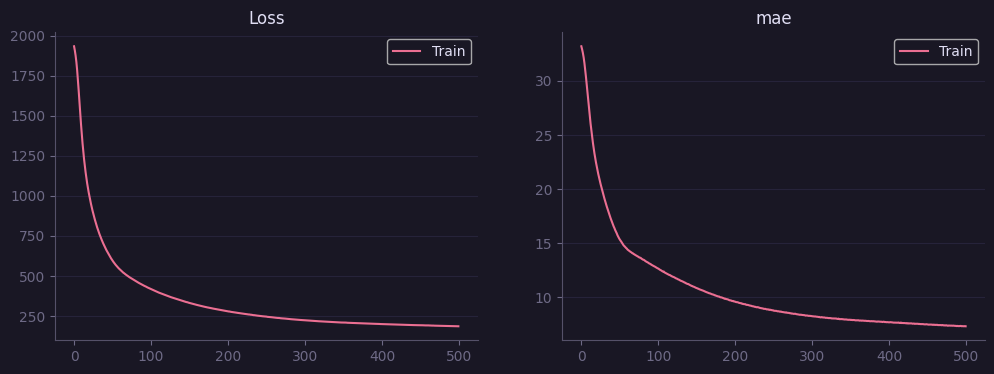

In [55]:
plot_loss_and_metric(nn_trial_hist, 'mae', val_present=False)

In [56]:
nn_preds = nn_trial.predict(nl_X_test_scaled)
print("Mean Absolute Error: ", mean_absolute_error(nl_y_test, nn_preds))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Mean Absolute Error:  7.53454212355274


Sięgnęliśmy po sieć, ale &hellip;

In [57]:
hist_regr = HistGradientBoostingRegressor(n_iter_no_change=10, max_iter=1000)

hist_regr.fit(nl_X_train_scaled, nl_y_train)
mean_absolute_error(hist_regr.predict(nl_X_test_scaled), nl_y_test)

2.707492155671618

No ale spokojna głowa &hellip;

### Frameworki

```mermaid
graph TB
    A[Pythonowe Frameworki]
    A --> C[Keras/Tensorflow] --- R(komercyjnie nadal mocno wykorzystywany)
    A --> B[PyTorch] --- S(najpopularniejszy obecnie)
    A --> P[Jax family] --- Q(przyszły top?)
    A --> E[Theano] --- Y(stare)
    A --> G[Chainer] --- O(nieużywane)
    A --> I[Caffe] --- L(stare)

```

<!-- ok, but the names should be aligned horizontally - make correction to mermaid graph -->



### FFN &mdash; Feed Forward Network (ciekawszy przykład)

In [60]:
nasa_df = pd.read_csv(os.path.join('data', 'nasa.csv'))

In [61]:
nasa_df = (
    nasa_df.drop(['Close Approach Date', 'Orbiting Body', 
                  'Orbit Determination Date', 'Equinox',
                  'Neo Reference ID', 'Name'], axis=1)
)

In [62]:
nasa_df.head()

,Absolute Magnitude,Est Dia in KM(min),Est Dia in KM(max),Est Dia in M(min),Est Dia in M(max),Est Dia in Miles(min),Est Dia in Miles(max),Est Dia in Feet(min),Est Dia in Feet(max),Epoch Date Close Approach,...,Inclination,Asc Node Longitude,Orbital Period,Perihelion Distance,Perihelion Arg,Aphelion Dist,Perihelion Time,Mean Anomaly,Mean Motion,Hazardous
0,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,788947200000,...,6.025981,314.373913,609.599786,0.808259,57.257470,2.005764,2.458162e+06,264.837533,0.590551,True
1,21.3,0.146068,0.326618,146.067964,326.617897,0.090762,0.202951,479.225620,1071.581063,788947200000,...,28.412996,136.717242,425.869294,0.718200,313.091975,1.497352,2.457795e+06,173.741112,0.845330,False
2,20.3,0.231502,0.517654,231.502122,517.654482,0.143849,0.321655,759.521423,1698.341531,789552000000,...,4.237961,259.475979,643.580228,0.950791,248.415038,1.966857,2.458120e+06,292.893654,0.559371,True
3,27.4,0.008801,0.019681,8.801465,19.680675,0.005469,0.012229,28.876199,64.569144,790156800000,...,7.905894,57.173266,514.082140,0.983902,18.707701,1.527904,2.457902e+06,68.741007,0.700277,False
4,21.6,0.127220,0.284472,127.219879,284.472297,0.079051,0.176763,417.388066,933.308089,790156800000,...,16.793382,84.629307,495.597821,0.967687,158.263596,1.483543,2.457814e+06,135.142133,0.726395,True


In [63]:
nasa_X, nasa_y = nasa_df.drop('Hazardous', axis=1), nasa_df['Hazardous']
nasa_y = nasa_y.to_numpy().astype(int)

nasa_X_train, nasa_X_test, nasa_y_train, nasa_y_test = train_test_split(nasa_X, nasa_y, test_size=0.2)

nasa_X_train_scaled, nasa_X_test_scaled = get_standarized_data(nasa_X_train, nasa_X_test)

In [249]:
nasa_nn = Sequential()

nasa_nn.add(Input(shape=(nasa_X_train_scaled.shape[1], )))
nasa_nn.add(Dense(200, activation='relu'))
nasa_nn.add(Dropout(0.2))
nasa_nn.add(Dense(100, activation='relu'))
nasa_nn.add(Dropout(0.2))
nasa_nn.add(Dense(1, activation='sigmoid'))

nasa_nn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
nasa_nn.summary()

Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_67 (Dense)                │ (None, 200)            │         6,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,001 (105.47 KB)

 Trainable params: 27,001 (105.47 KB)

 Non-trainable params: 0 (0.00 B)

In [250]:
nasa_nn_hist = nasa_nn.fit(nasa_X_train_scaled, nasa_y_train, epochs=20)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8447 - loss: 0.3571
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9363 - loss: 0.1497
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9595 - loss: 0.1033
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9610 - loss: 0.0969
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9665 - loss: 0.0749
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9674 - loss: 0.0765
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9770 - loss: 0.0567
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9796 - loss: 0.0571
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9760 - loss: 0.0548
Epoch 10/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9837 - loss: 0.0441
Epoch 11/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9820 - loss: 0.0408
Epoch 12/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [251]:
na_preds = nasa_nn.predict(nasa_X_test_scaled)
na_preds = np.where(na_preds > 0.5, 1, 0)

print("Accuracy: ", np.mean(na_preds.flatten() == nasa_y_test.astype(int).flatten()))

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy:  0.9840085287846482


Zaimplementujmy tę samą sięć w PyTorchu.

In [78]:
class NasaNN(nn.Module):

    def __init__(self, ):
        super(NasaNN, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(nasa_X_train_scaled.shape[1], 200),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.layers(x)
    

nasa_nn_torch = NasaNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(nasa_nn_torch.parameters(), lr=0.001)

nasa_X_train_scaled_dataset = TensorDataset(torch.from_numpy(nasa_X_train_scaled), 
                                             torch.from_numpy(nasa_y_train))
nasa_train_loader = DataLoader(nasa_X_train_scaled_dataset, batch_size=32, shuffle=True)

nasa_X_test_tensor = torch.from_numpy(nasa_X_test_scaled)

In [79]:
epochs = 20

for epoch in range(epochs):
    nasa_nn_torch.train()
    for data, target in nasa_train_loader:
        optimizer.zero_grad()
        output = nasa_nn_torch(data.float())
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 0.19954466819763184
Epoch: 1, Loss: 0.17284230887889862
Epoch: 2, Loss: 0.016658196225762367
Epoch: 3, Loss: 0.08637313544750214
Epoch: 4, Loss: 0.0002316709142178297
Epoch: 5, Loss: 9.695534572529141e-06
Epoch: 6, Loss: 0.07783007621765137
Epoch: 7, Loss: 1.5885536413406953e-05
Epoch: 8, Loss: 0.02459822967648506
Epoch: 9, Loss: 0.010370557196438313
Epoch: 10, Loss: 0.0729750245809555
Epoch: 11, Loss: 0.005020823795348406
Epoch: 12, Loss: 0.0690559595823288
Epoch: 13, Loss: 0.020896971225738525
Epoch: 14, Loss: 0.20724113285541534
Epoch: 15, Loss: 0.005622213706374168
Epoch: 16, Loss: 0.0021660509519279003
Epoch: 17, Loss: 0.00437843706458807
Epoch: 18, Loss: 0.010019948706030846
Epoch: 19, Loss: 7.586251740576699e-06


In [80]:
nasa_nn_torch.eval()

nasa_nn_torch_preds = nasa_nn_torch(nasa_X_test_tensor.float())
numpy_preds = np.asarray(nasa_nn_torch_preds.detach())

numpy_preds = np.where(numpy_preds > 0.5, 1, 0)

print("Accuracy: ", np.mean(numpy_preds.flatten() == nasa_y_test.astype(int).flatten()))

Accuracy:  0.9829424307036247


### CNN

Bardzo dobre wytłumaczenie CNN można znaleźć [tutaj](https://poloclub.github.io/cnn-explainer/).

In [37]:
weather_path = os.path.join("data", "weather")

file_paths = []
class_labels = []
for i in os.listdir(weather_path):
    for sub_file in os.listdir(os.path.join(weather_path, i)):
        file_paths.append(os.path.join(weather_path, i, sub_file))
        class_labels.append(''.join([i for i in sub_file.split('.')[0] if i.isalpha()]))

dataset_df = pd.DataFrame({'filepaths': file_paths, 'labels': class_labels})
dataset_df.head()

,filepaths,labels
0,data\weather\cloudy\cloudy1.jpg,cloudy
1,data\weather\cloudy\cloudy10.jpg,cloudy
2,data\weather\cloudy\cloudy100.jpg,cloudy
3,data\weather\cloudy\cloudy101.jpg,cloudy
4,data\weather\cloudy\cloudy102.jpg,cloudy


In [38]:
train_df, test_valid_df = train_test_split(dataset_df, train_size=0.8, shuffle= True,
                                           random_state=30_08_2000, stratify=dataset_df.labels)
valid_df, test_df = train_test_split(test_valid_df, train_size= 0.6, shuffle= True, 
                                     random_state=30_08_2000, stratify=test_valid_df.labels)

In [39]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

In [40]:
ts_length = len(test_df)
test_batch_size = 16

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode= 'categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, 
                                       class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, 
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)

Found 900 validated image filenames belonging to 4 classes.
Found 135 validated image filenames belonging to 4 classes.
Found 90 validated image filenames belonging to 4 classes.


In [41]:
cnn = Sequential()

cnn.add(Input(shape=(224, 224, 3)))
cnn.add(Conv2D(32, (3, 3), activation='relu'))
cnn.add(MaxPooling2D((3, 3)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, (5, 5), activation='relu'))
cnn.add(MaxPooling2D((3, 3)))
cnn.add(Dropout(0.2))
cnn.add(Conv2D(64, (4, 4), activation='relu'))
cnn.add(MaxPooling2D((3, 3)))
cnn.add(Flatten())
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.3))
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=['accuracy'])
cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 70, 70, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 20, 20, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,700 (1.03 MB)

 Trainable params: 269,700 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
cnn_hist = cnn.fit(train_gen, validation_data=valid_gen, epochs=10, verbose=1)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 14s 697ms/step - accuracy: 0.2891 - loss: 1.3692 - val_accuracy: 0.5259 - val_loss: 0.9901
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 597ms/step - accuracy: 0.5488 - loss: 0.8846 - val_accuracy: 0.6815 - val_loss: 0.8498
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 614ms/step - accuracy: 0.5799 - loss: 0.8313 - val_accuracy: 0.7704 - val_loss: 0.8747
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 580ms/step - accuracy: 0.6916 - loss: 0.7825 - val_accuracy: 0.7778 - val_loss: 0.6775
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 584ms/step - accuracy: 0.6674 - loss: 0.7285 - val_accuracy: 0.6963 - val_loss: 0.6618
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 577ms/step - accuracy: 0.6997 - loss: 0.6978 - val_accuracy: 0.8074 - val_loss: 0.4826
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 581ms/step - accuracy: 0.7464 - loss: 0.5973 - val_accuracy: 0.8593 - val_loss: 0.4153
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 591ms/step - accuracy: 0.7946 - loss: 0.5293 - val_accu

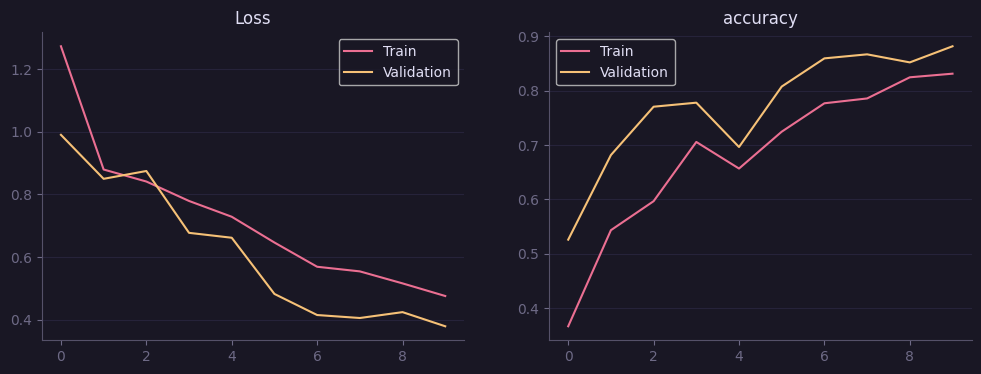

In [36]:
plot_loss_and_metric(cnn_hist, 'accuracy')

In [32]:
preds = cnn.predict(test_gen)

np.mean(np.argmax(preds, axis=1) == test_gen.classes)

3/9 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 

c:\Users\Manik\projects\DM-warsztat\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


### LSTM

<img src="media/lstm.png" width='80%' height='50%'>

In [425]:
time_series_data = np.load(os.path.join('data', 'time_series.npz'))
time_series_X, time_series_y = time_series_data['X'], time_series_data['labels']

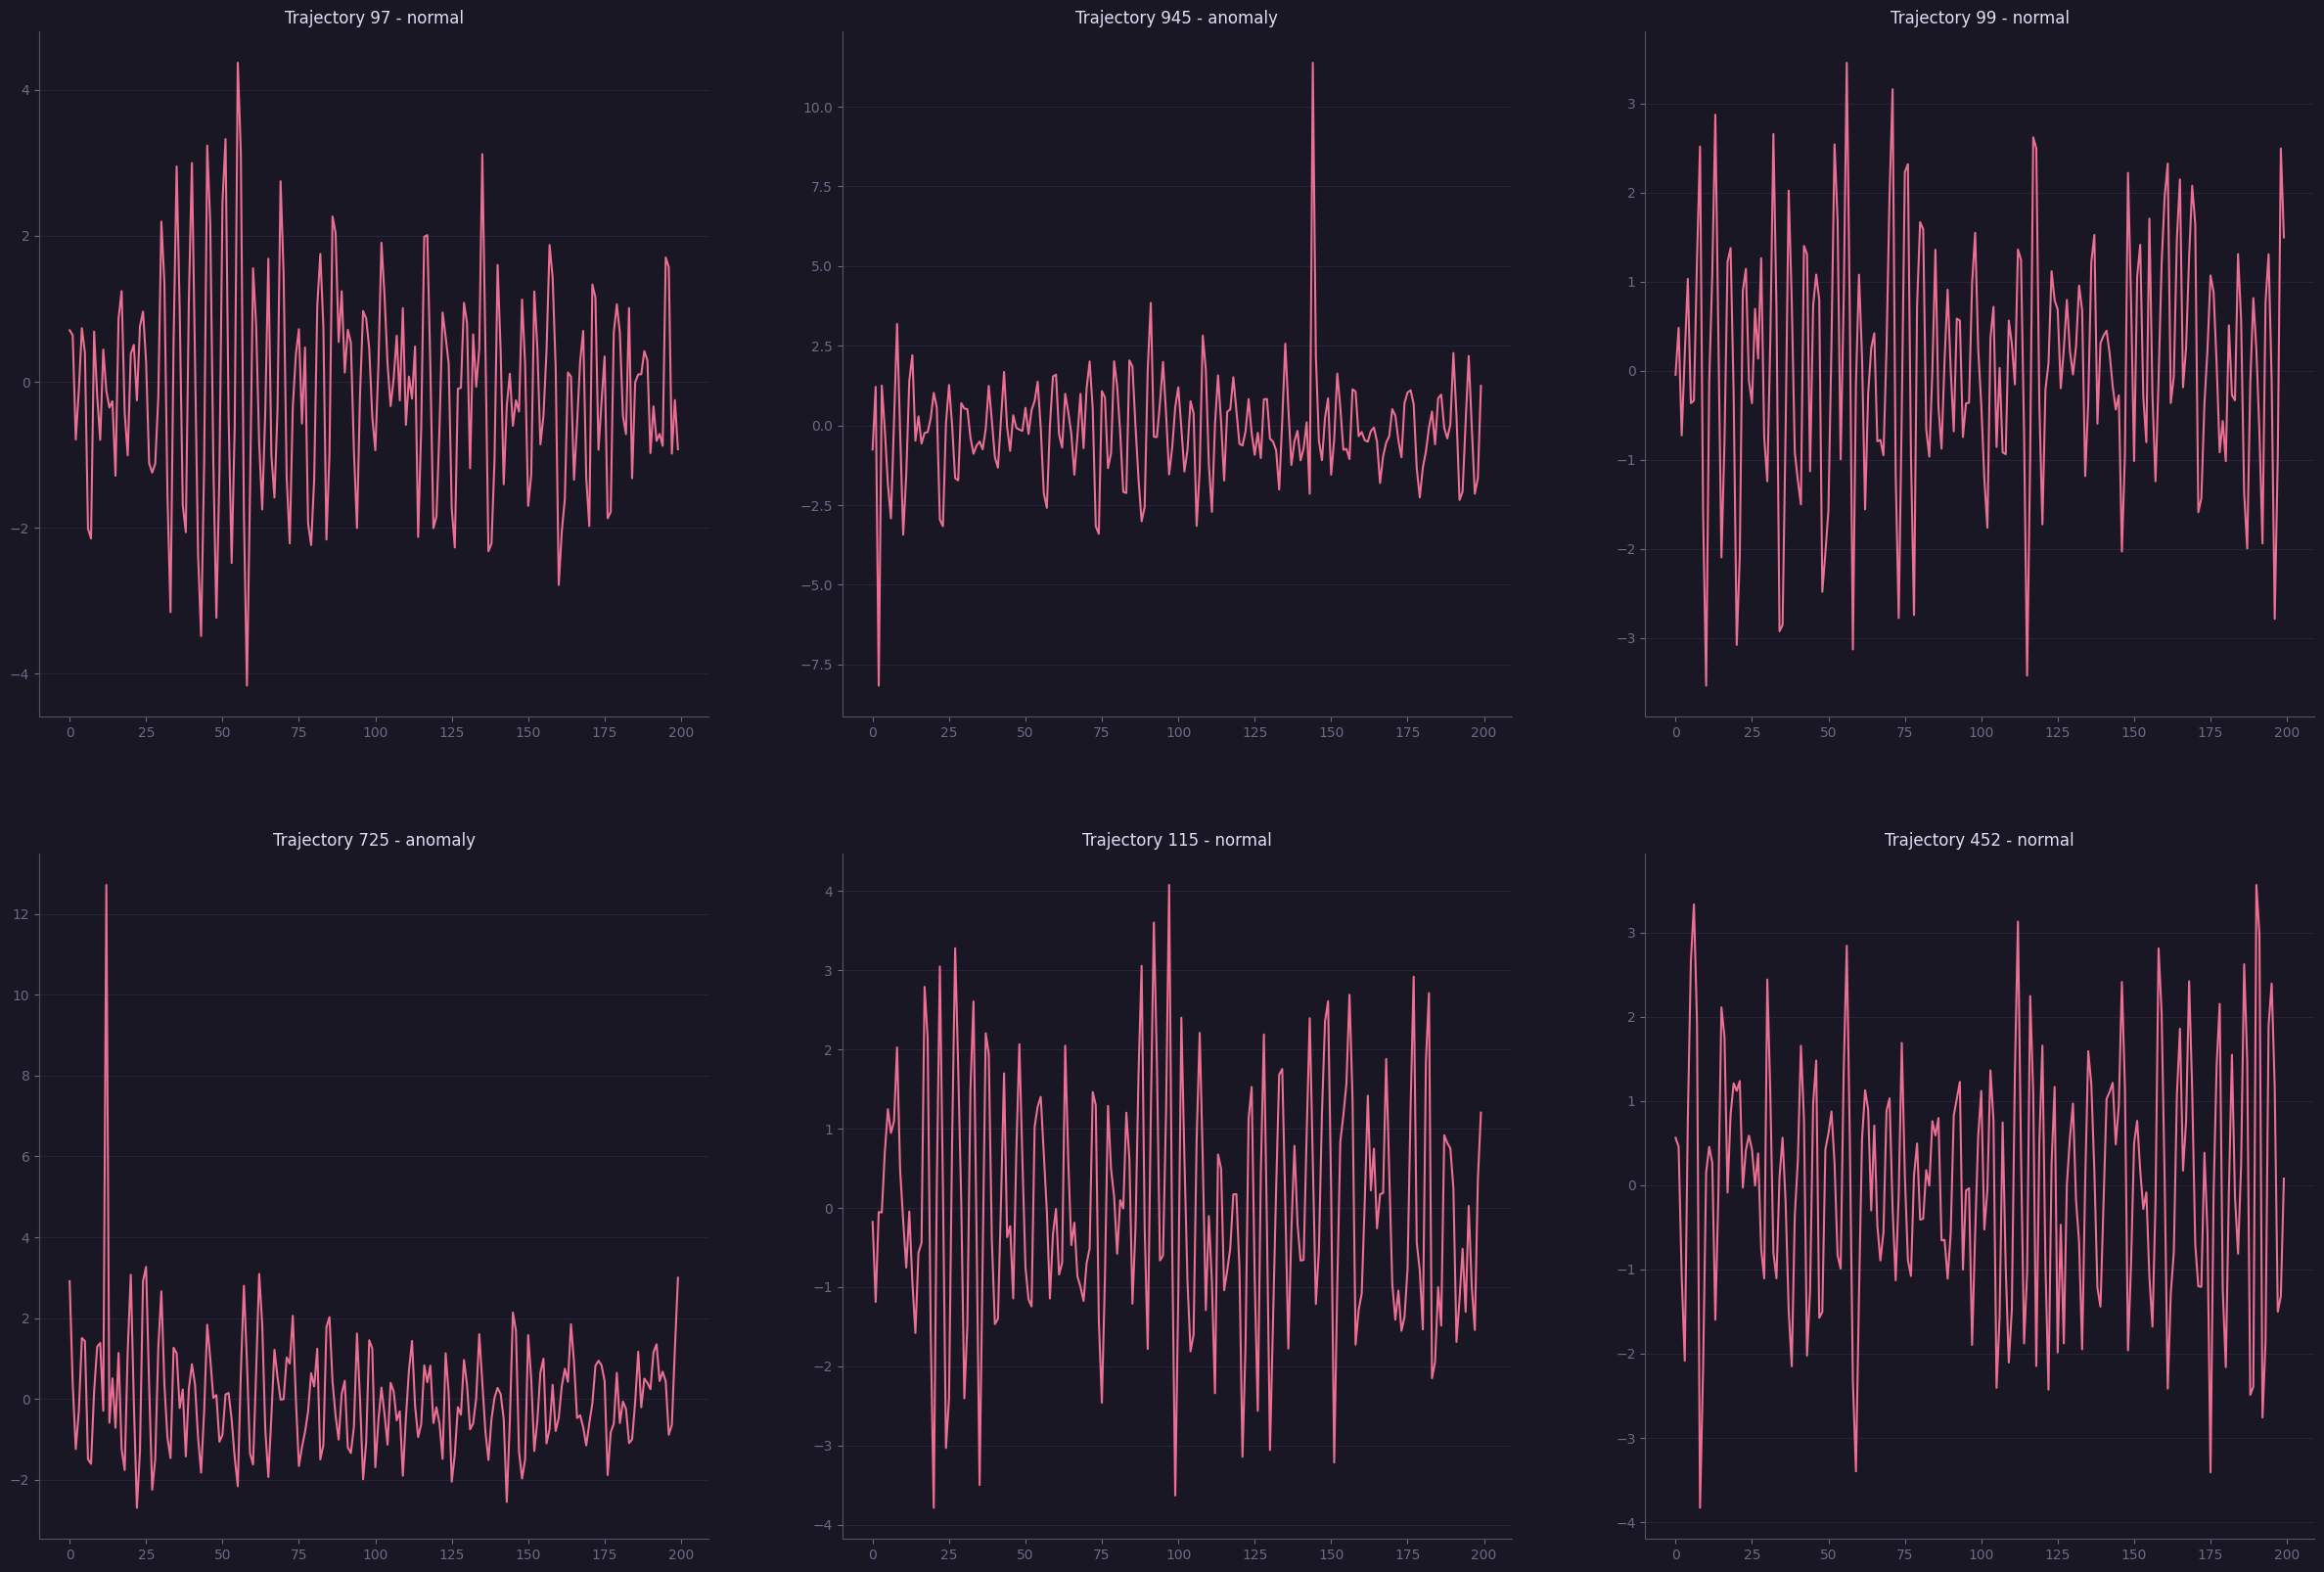

In [426]:
fig, ax = plt.subplots(2, 3, figsize=(30, 20))

np.random.seed(SEED)
random_indices = np.random.choice(time_series_X.shape[1], 6)

for i, axi in enumerate(ax.flat):
    idx = random_indices[i]
    axi.plot(time_series_X[:, idx])
    axi.set_title(f"Trajectory {idx} - {'anomaly' if time_series_y[idx] == 1 else 'normal'}")

In [427]:
time_series_X = StandardScaler().fit_transform(time_series_X)

In [428]:
time_series_X = time_series_X.transpose(1, 0)
time_series_X = np.reshape(time_series_X, (time_series_X.shape[0], time_series_X.shape[1], 1))

time_series_X_train, time_series_X_test, time_series_y_train, time_series_y_test = \
    train_test_split(time_series_X, time_series_y, test_size=0.2, stratify=time_series_y)

In [429]:
lstm_dataset_train = tf.data.Dataset.from_tensor_slices((time_series_X_train, time_series_y_train.reshape(-1, 1)))
lstm_dataset_train = lstm_dataset_train.shuffle(1000).batch(32)
lstm_dataset_test = tf.data.Dataset.from_tensor_slices((time_series_X_test, time_series_y_test.reshape(-1, 1)))
lstm_dataset_test = lstm_dataset_test.batch(32)

Niżej proponuję się pobawić proporcją w warstwie `Dropout`.

In [432]:
lstm_model = Sequential()

lstm_model.add(Input(shape=(200, 1)))
lstm_model.add(LSTM(256))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(128, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

lstm_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_104 (Dense)               │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,409 (1.17 MB)

 Trainable params: 305,409 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [433]:
lstm_hist = lstm_model.fit(lstm_dataset_train, epochs=15)

Epoch 1/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.5677 - loss: 0.6884
Epoch 2/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.7408 - loss: 0.6503
Epoch 3/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8497 - loss: 0.5962
Epoch 4/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 0.8506 - loss: 0.5714
Epoch 5/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8566 - loss: 0.5305
Epoch 6/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8870 - loss: 0.4369
Epoch 7/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.8645 - loss: 0.4201
Epoch 8/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.9018 - loss: 0.3419
Epoch 9/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8408 - loss: 0.4153
Epoch 10/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.8943 - loss: 0.3365
Epoch 11/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.8942 - loss: 0.3020
Epoch 12/15
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step

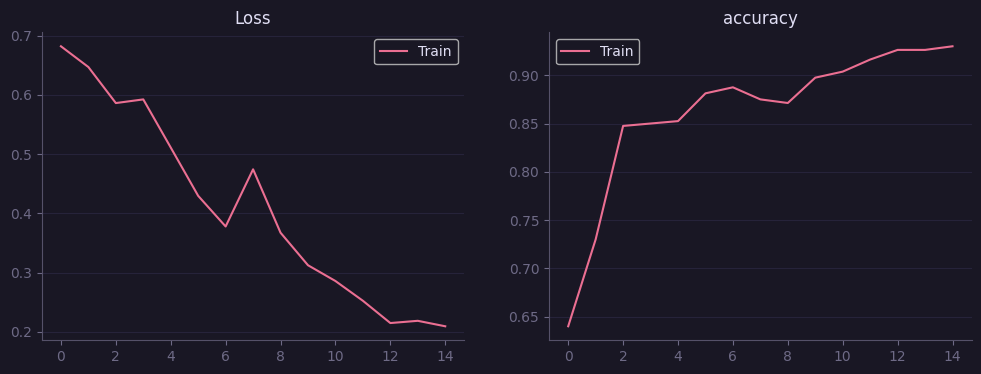

In [434]:
plot_loss_and_metric(lstm_hist, metric="accuracy", val_present=False)

In [435]:
preds = lstm_model.predict(lstm_dataset_test)
preds = np.where(preds > 0.5, 1, 0)

print("Accuracy: ", np.mean(preds.flatten() == time_series_y_test))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Accuracy:  0.93


In [436]:
time_series_X_train_r = time_series_X_train.reshape(time_series_X_train.shape[:-1])
time_series_X_test_r = time_series_X_test.reshape(time_series_X_test.shape[:-1])

In [437]:
rocket = ROCKET()
rocket.fit(time_series_X_train_r)

rocket_X_train = rocket.transform(time_series_X_train_r)
rocket_X_test = rocket.transform(time_series_X_test_r)

In [438]:
rocket_X_train, rocket_X_test = get_standarized_data(rocket_X_train, rocket_X_test)

In [439]:
ridge = RidgeClassifier()

ridge.fit(rocket_X_train, time_series_y_train)
ridge_preds = ridge.predict(rocket_X_test)

print("Accuracy: ", np.mean(ridge_preds == time_series_y_test))

Accuracy:  0.95


# Koniec